In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.graphics.tsaplots import plot_acf
import datetime
from datetime import datetime
from datetime import timedelta 

In [2]:
df_2022_2024 = pd.read_csv("data/2022-2024_Stats.csv")
df_2022_2024

,Date,Open Balances,Closed,New Cases
0,2022-01-01,1963,0,468
1,2022-01-02,2431,0,503
2,2022-01-03,2934,857,1212
3,2022-01-04,3146,727,1039
4,2022-01-05,3368,949,826
...,...,...,...,...
810,2024-03-21,2521,429,428
811,2024-03-22,2499,432,406
812,2024-03-23,2473,11,211
813,2024-03-24,2673,0,214


In [3]:
df_2022_2024.set_index('Date', inplace=True)

train_data, test_data = df_2022_2024[0:int(len(df_2022_2024)*0.9)], df_2022_2024[int(len(df_2022_2024)*0.9):]

train_arima = train_data['Open Balances']
test_arima = test_data['Open Balances']

# ARIMA Model

In [10]:
# Initialize history with training data
history = [x for x in train_arima]
y = test_arima
predictions = list()
residuals = list()  # List to store residuals

# Iterate over test data to make predictions
for i in range(0, len(y)):
    model = ARIMA(history, order=(7,1,0)) # p, d, q
    model_fit = model.fit()
    # Forecast the next value
    yhat = model_fit.forecast()[0]
    # Append the forecasted value to predictions
    predictions.append(yhat)
    # Get the observation from test data
    obs = y[i]
    # Calculate residual
    residual = obs - yhat
    residuals.append(residual)
    # Update the history with the observation
    history.append(obs)

In [11]:
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 15337.774066382448
MAE: 99.08482432085894
RMSE: 123.84576725258901


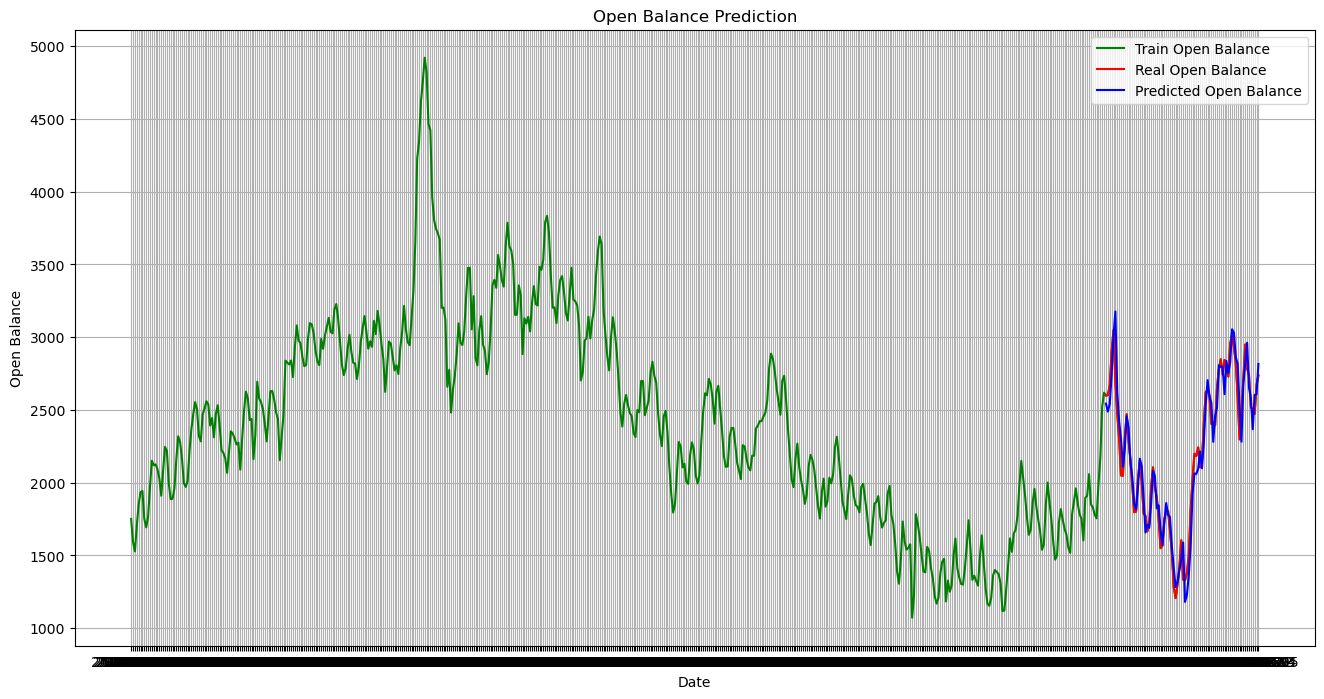

In [12]:
plt.figure(figsize=(16,8))
plt.plot(df_2022_2024.index[-600:], df_2022_2024['Open Balances'].tail(600), color='green', label = 'Train Open Balance')
plt.plot(test_data.index, y, color = 'red', label = 'Real Open Balance')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Open Balance')
plt.title('Open Balance Prediction')
plt.xlabel('Date')
plt.ylabel('Open Balance')
plt.legend()
plt.grid(True)
plt.show()

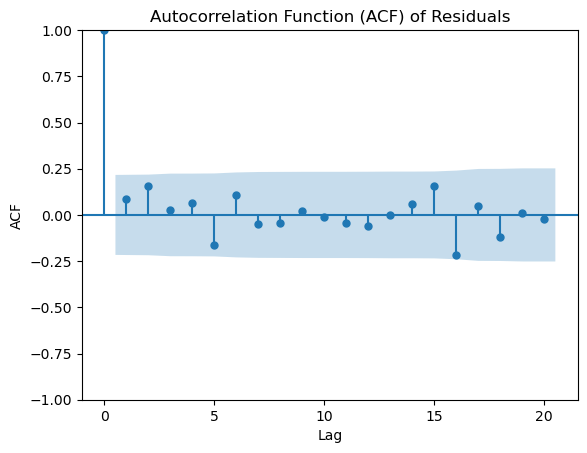

In [8]:
plot_acf(residuals, lags=20)  # Adjust 'lags' as needed
plt.title('Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

## Predicting for 2024, by Week

In [92]:
last_2_months = df_2022_2024[-90:-30]
print(len(last_2_months))

60


In [93]:
# Combine training data from 2022 and 2023
combined_train_data = last_2_months['Open Balances'] # Assuming test_arima contains data for 2022 and 2023

# Initialize history with combined training data
history = [x for x in combined_train_data]

predictions_2024 = list()


# Number of time steps to forecast for 2024
num_steps_2024 = 7

# Iterate over the number of time steps to make predictions for 2024
for i in range(num_steps_2024):
    # Fit ARIMA model with seasonal differencing
    model = ARIMA(history, order=(7, 1, 1)) # 7, 1, 0 is the best combination
    model_fit = model.fit()
    
    # Forecast the next value
    yhat = model_fit.forecast()[0]
    # Append the forecasted value to predictions
    predictions_2024.append(yhat)
    
    # Update the history with the forecasted value
    history.append(yhat)

# Now predictions_2024 contains the predicted values for 2024

print(predictions_2024)

[2319.012550019357, 2443.0052824526388, 2546.464894383875, 2554.302971585926, 2537.1875834820125, 2450.0301150081277, 2469.436017403528]


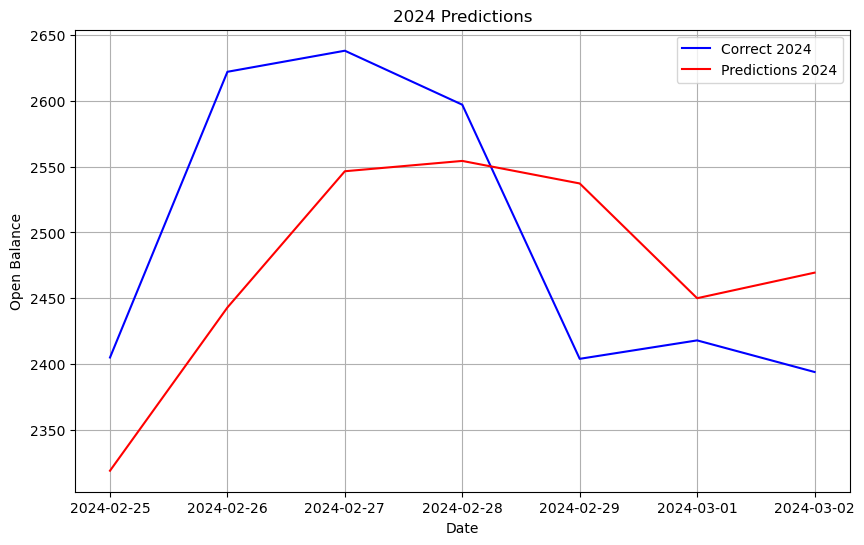

MSE: 10584.302234642548
MAE: 91.4097167788387
RMSE: 102.88003807659943
Measure error compared to the scale of actual values : 3.660991059914584


In [94]:
# Assuming your original data is in a pandas Series or DataFrame format
# and the index is a datetime index
# Create a time index for the 2024 period
start_date_2024 = pd.Timestamp('2024-02-25')
end_date_2024 = start_date_2024 + datetime.timedelta(days=6)
time_index_2024 = pd.date_range(start=start_date_2024, end=end_date_2024, freq='D')

filtered_values = df_2022_2024.loc[str(start_date_2024.date()):str(end_date_2024.date()), 'Open Balances']

# # Plotting
plt.figure(figsize=(10, 6))

plt.plot(time_index_2024, filtered_values, label='Correct 2024', color='blue')

# Plot predicted values for 2024
plt.plot(time_index_2024, predictions_2024, label='Predictions 2024', color='red')

plt.title('2024 Predictions')
plt.xlabel('Date')
plt.ylabel('Open Balance')
plt.legend()
plt.grid(True)
plt.show()

# report performance
mse = mean_squared_error(filtered_values, predictions_2024)
print('MSE: '+str(mse))
mae = mean_absolute_error(filtered_values, predictions_2024)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(filtered_values, predictions_2024))
print('RMSE: '+str(rmse))

mean_actual_values = filtered_values.mean()
error_percentage = (mae / mean_actual_values) * 100
print("Measure error compared to the scale of actual values :", error_percentage)

## Predicting for 2024, by Month

In [95]:
last_100_days = df_2022_2024[-130:-30]
print(len(last_100_days))

100


In [96]:
# Combine training data from 2022 and 2023
combined_train_data = last_100_days['Open Balances'] # Assuming test_arima contains data for 2022 and 2023

# Initialize history with combined training data
history = [x for x in combined_train_data]

predictions_2024 = list()


# Number of time steps to forecast for 2024
num_steps_2024 = 30

# Iterate over the number of time steps to make predictions for 2024
for i in range(num_steps_2024):
    # Fit ARIMA model with seasonal differencing
    model = ARIMA(history, order=(7, 1, 1)) # 7, 1, 0 is the best combination
    model_fit = model.fit()
    
    # Forecast the next value
    yhat = model_fit.forecast()[0]
    # Append the forecasted value to predictions
    predictions_2024.append(yhat)
    
    # Update the history with the forecasted value
    history.append(yhat)

# Now predictions_2024 contains the predicted values for 2024

print(predictions_2024)

[2310.3908605415027, 2442.1285856952577, 2550.0566774702684, 2541.1237203262754, 2535.0970020431387, 2417.3723961642877, 2425.015377210721, 2504.4318934284975, 2594.66849150132, 2670.1428948365465, 2671.0389221186333, 2646.4437959086486, 2555.084217181012, 2545.3649544011346, 2583.2964204040854, 2647.87158867249, 2704.94201711114, 2713.1856934441766, 2687.816401103672, 2619.875676906129, 2602.03262044935, 2618.493517586613, 2665.074485641766, 2709.7514990216137, 2722.1697430251374, 2701.969562346561, 2652.3718643866014, 2631.7164631511787, 2636.7677985515056, 2669.974501773713]


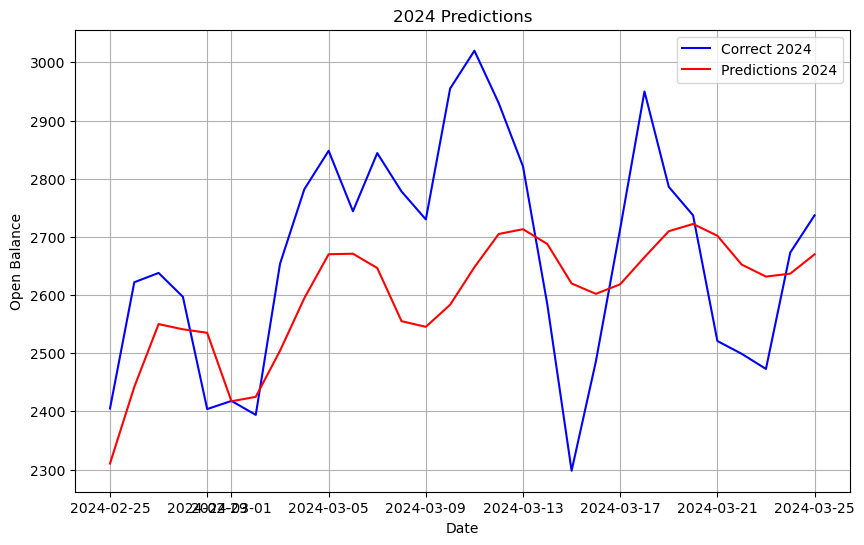

MSE: 31263.66900092048
MAE: 148.67067642639086
RMSE: 176.81535284279045
Measure error compared to the scale of actual values : 5.572224947892014


In [97]:
# Assuming your original data is in a pandas Series or DataFrame format
# and the index is a datetime index
# Create a time index for the 2024 period
start_date_2024 = pd.Timestamp('2024-02-25')
end_date_2024 = start_date_2024 + datetime.timedelta(days=29)
time_index_2024 = pd.date_range(start=start_date_2024, end=end_date_2024, freq='D')

filtered_values = df_2022_2024.loc[str(start_date_2024.date()):str(end_date_2024.date()), 'Open Balances']

# # Plotting
plt.figure(figsize=(10, 6))

plt.plot(time_index_2024, filtered_values, label='Correct 2024', color='blue')

# Plot predicted values for 2024
plt.plot(time_index_2024, predictions_2024, label='Predictions 2024', color='red')

plt.title('2024 Predictions')
plt.xlabel('Date')
plt.ylabel('Open Balance')
plt.legend()
plt.grid(True)
plt.show()

# report performance
mse = mean_squared_error(filtered_values, predictions_2024)
print('MSE: '+str(mse))
mae = mean_absolute_error(filtered_values, predictions_2024)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(filtered_values, predictions_2024))
print('RMSE: '+str(rmse))

mean_actual_values = filtered_values.mean()
error_percentage = (mae / mean_actual_values) * 100
print("Measure error compared to the scale of actual values :", error_percentage)

## Dynamic Updating of ARIMA by Week

In [ ]:
df_2022_2024_testing = df_2022_2024.copy()
df_2022_2024_testing = df_2022_2024_testing[-90:]

df_2022_2024_testing.set_index('Date', inplace=True)
df_2022_2024_testing

In [ ]:
open_balance_input = input("Enter today's Open Balance: ")
close_balance_input = input("Enter today's Close Balance: ")
new_balance_input = input("Enter today's New Balance: ")

try:
    open_balance = float(open_balance_input)
    close_balance = float(close_balance_input)
    new_balance = float(new_balance_input)
except ValueError:
    print("Error: Please enter valid numbers for balances.")
else:
    #today_date = datetime.now().strftime('%Y-%m-%d')  # Get today's date in YYYY-MM-DD format
    new_data = {'Open Balances': open_balance,
                'Closed': close_balance,
                'New Cases': new_balance
                } 
    df_2022_2024_testing = df_2022_2024_testing.append(new_data, ignore_index=True)
    print("Values successfully added to DataFrame.")
    print(df_2022_2024_testing[-7:])
    
df_2022_2024_testing

In [180]:
# # Initialize an empty list to store predictions for 2024
predictions_2024 = []

# Number of time steps to forecast for each update
num_steps_2024 = 7

combined_train_data = df_2022_2024_testing['Open Balances']
history = combined_train_data.tolist()

if len(combined_train_data) >= 90:
    
    history.pop(0)  # Remove the oldest value from history
    combined_train_data.pop(0) # Remove the oldest value from combined_train_data
    df_2022_2024_testing = df_2022_2024_testing.drop(df_2022_2024_testing.index[0])
    
# Make predictions for the next 7 days
for i in range(num_steps_2024):
    # Fit ARIMA model with seasonal differencing
    model = ARIMA(history, order=(7, 1, 1)) # 7, 1, 0 is the best combination
    model_fit = model.fit()
    
    # Forecast the next value
    yhat = model_fit.forecast()[0]
    # Append the forecasted value to predictions
    predictions_2024.append(yhat)
    
    # Update the history with the forecasted value
    history.append(yhat)
    
    
#combined_train_data.pop(0)  

# Now predictions_2024 contains the predicted values for 2024
print(len(combined_train_data))
print(predictions_2024)


90
[2138.629336947407, 2010.573441650842, 2002.837287086204, 2074.631375454121, 2250.238442252012, 2222.4239988418435, 2026.702025999898]


In [181]:
print(len(history))
print(history)

97
[1831.0, 1780.0, 1755.0, 1987.0, 2173.0, 2524.0, 2619.0, 2599.0, 2602.0, 2668.0, 2899.0, 3048.0, 2700.0, 2475.0, 2299.0, 2050.0, 2048.0, 2308.0, 2470.0, 2286.0, 2158.0, 1980.0, 1797.0, 1802.0, 2026.0, 2153.0, 2002.0, 1790.0, 1771.0, 1666.0, 1713.0, 1973.0, 2106.0, 1966.0, 1899.0, 1752.0, 1550.0, 1567.0, 1746.0, 1809.0, 1807.0, 1676.0, 1521.0, 1284.0, 1207.0, 1299.0, 1417.0, 1604.0, 1334.0, 1329.0, 1379.0, 1500.0, 1811.0, 2023.0, 2199.0, 2184.0, 2242.0, 2106.0, 2148.0, 2405.0, 2622.0, 2638.0, 2597.0, 2404.0, 2418.0, 2394.0, 2654.0, 2782.0, 2848.0, 2744.0, 2844.0, 2778.0, 2730.0, 2955.0, 3020.0, 2930.0, 2821.0, 2584.0, 2298.0, 2486.0, 2714.0, 2950.0, 2786.0, 2737.0, 2521.0, 2499.0, 2473.0, 2673.0, 2737.0, 2341.0, 2138.629336947407, 2010.573441650842, 2002.837287086204, 2074.631375454121, 2250.238442252012, 2222.4239988418435, 2026.702025999898]


In [182]:
# start_date_2024 = pd.Timestamp.today().date()
# print(start_date_2024)
combined_train_data
df_2022_2024_testing

,Open Balances,Closed,New Cases
1,1831.0,447.0,498.0
2,1780.0,426.0,401.0
3,1755.0,0.0,232.0
4,1987.0,0.0,186.0
5,2173.0,3.0,406.0
...,...,...,...
86,2499.0,432.0,406.0
87,2473.0,11.0,211.0
88,2673.0,0.0,214.0
89,2737.0,466.0,445.0


In [183]:
# turn dataframe back into date index
today_date = pd.to_datetime('2024-03-26')

# 90 days prior
start_historical_date = today_date - timedelta(days=89)
# date range for 90 days
historical_date_range = pd.date_range(start=start_historical_date, end=today_date, freq='D')
print(len(historical_date_range))
# make date the index
df_2022_2024_testing.index = historical_date_range

df_2022_2024_testing

90


,Open Balances,Closed,New Cases
2023-12-28,1831.0,447.0,498.0
2023-12-29,1780.0,426.0,401.0
2023-12-30,1755.0,0.0,232.0
2023-12-31,1987.0,0.0,186.0
2024-01-01,2173.0,3.0,406.0
...,...,...,...
2024-03-22,2499.0,432.0,406.0
2024-03-23,2473.0,11.0,211.0
2024-03-24,2673.0,0.0,214.0
2024-03-25,2737.0,466.0,445.0


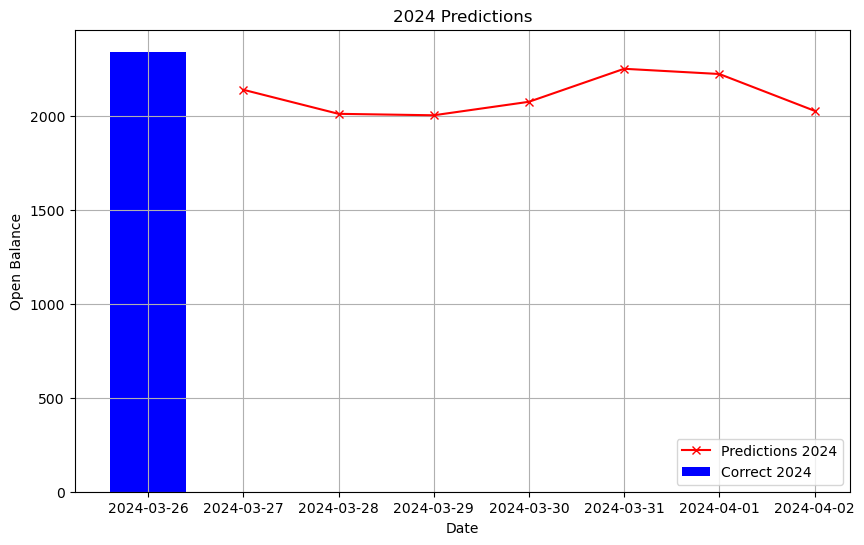

In [186]:
# Sample data for filtered_values
filtered_values = df_2022_2024_testing['Open Balances'][-1:]

# Calculate the start and end dates for predictions
pred_start_date = pd.Timestamp('2024-03-27')
pred_end_date = pred_start_date + pd.Timedelta(days=6)
time_index_2024 = pd.date_range(start=pred_start_date, end=pred_end_date, freq='D')

# Plotting
plt.figure(figsize=(10, 6))

# Plot filtered_values as a bar plot
plt.bar(df_2022_2024_testing.index[-1:], filtered_values, label='Correct 2024', color='blue')

# Plot predicted values for 2024 as a line plot
plt.plot(time_index_2024, predictions_2024, marker='x', label='Predictions 2024', color='red')

plt.title('2024 Predictions')
plt.xlabel('Date')
plt.ylabel('Open Balance')
plt.legend()
plt.grid(True)
plt.show()


# Archived Models

## SARIMA Model (Not going to be used)

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [15]:
# Initialize history with training data
history = [x for x in train_arima]
y = test_arima
predictions = list()
residuals = list()

# SARIMA seasonal differencing parameters
seasonal_order = (0, 1, 1, 12)  # (P, D, Q, s)

# Iterate over test data to make predictions
for i in range(0, len(y)):
    # Fit SARIMA model with seasonal differencing
    model = SARIMAX(history, order=(3, 1, 1), seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    # Forecast the next value
    yhat = model_fit.forecast()[0]
    # Append the forecasted value to predictions
    predictions.append(yhat)
    
    # Get the observation from test data
    obs = y[i]
    
    # Calculate residual
    residual = obs - yhat
    residuals.append(residual)
    
    # Update the history with the observation
    history.append(obs)

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12846D+00    |proj g|=  6.08062D-01

At iterate    5    f=  6.83506D+00    |proj g|=  1.87271D-02

At iterate   10    f=  6.83102D+00    |proj g|=  2.90030D-03

At iterate   15    f=  6.83040D+00    |proj g|=  7.36816D-03

At iterate   20    f=  6.79814D+00    |proj g|=  1.81225D-01

At iterate   25    f=  6.65752D+00    |proj g|=  1.68118D-02

At iterate   30    f=  6.65333D+00    |proj g|=  4.67267D-03

At iterate   35    f=  6.65007D+00    |proj g|=  9.89882D-03

At iterate   40    f=  6.64841D+00    |proj g|=  2.32912D-03

At iterate   45    f=  6.64834D+00    |proj g|=  2.94673D-04

At iterate   50    f=  6.64834D+00    |proj g|=  2.23808D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12910D+00    |proj g|=  6.08278D-01


 This problem is unconstrained.



At iterate    5    f=  6.83556D+00    |proj g|=  1.84792D-02

At iterate   10    f=  6.83133D+00    |proj g|=  3.67802D-03

At iterate   15    f=  6.83089D+00    |proj g|=  3.95719D-03

At iterate   20    f=  6.80036D+00    |proj g|=  9.60872D-02

At iterate   25    f=  6.66987D+00    |proj g|=  4.30683D-02

At iterate   30    f=  6.66439D+00    |proj g|=  4.55014D-02

At iterate   35    f=  6.65064D+00    |proj g|=  9.48615D-03

At iterate   40    f=  6.64991D+00    |proj g|=  2.54192D-02

At iterate   45    f=  6.64811D+00    |proj g|=  3.92771D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.64798D+00    |proj g|=  8.07283D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   8.073D-04   6.648D+00
  F =   6.6479830714322814     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12877D+00    |proj g|=  6.08288D-01


 This problem is unconstrained.



At iterate    5    f=  6.83518D+00    |proj g|=  1.84662D-02

At iterate   10    f=  6.83096D+00    |proj g|=  3.66363D-03

At iterate   15    f=  6.83039D+00    |proj g|=  8.10906D-03

At iterate   20    f=  6.80178D+00    |proj g|=  1.30424D-01

At iterate   25    f=  6.66807D+00    |proj g|=  3.24191D-02

At iterate   30    f=  6.66708D+00    |proj g|=  1.23101D-02

At iterate   35    f=  6.64915D+00    |proj g|=  3.14151D-02

At iterate   40    f=  6.64800D+00    |proj g|=  2.33414D-04

At iterate   45    f=  6.64792D+00    |proj g|=  7.73085D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.64767D+00    |proj g|=  1.34168D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68      1     0     0   1.342D-03   6.648D+00
  F =   6.6476713844537105     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12844D+00    |proj g|=  6.08355D-01

At iterate    5    f=  6.83482D+00    |proj g|=  1.84845D-02

At iterate   10    f=  6.83060D+00    |proj g|=  3.65292D-03

At iterate   15    f=  6.82768D+00    |proj g|=  9.87049D-03

At iterate   20    f=  6.70624D+00    |proj g|=  1.01364D-01

At iterate   25    f=  6.67338D+00    |proj g|=  9.19708D-03

At iterate   30    f=  6.65684D+00    |proj g|=  3.70814D-02

At iterate   35    f=  6.64773D+00    |proj g|=  1.23090D-03

At iterate   40    f=  6.64769D+00    |proj g|=  3.48208D-03

At iterate   45    f=  6.64761D+00    |proj g|=  3.70012D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.64761D+00    |proj g|=  1.04427D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   1.044D-04   6.648D+00
  F =   6.6476067943544281     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13026D+00    |proj g|=  6.06294D-01

At iterate    5    f=  6.83683D+00    |proj g|=  1.82878D-02

At iterate   10    f=  6.83258D+00    |proj g|=  3.63453D-03

At iterate   15    f=  6.83208D+00    |proj g|=  6.97578D-03

At iterate   20    f=  6.77677D+00    |proj g|=  1.42344D-01

At iterate   25    f=  6.66796D+00    |proj g|=  7.25763D-03

At iterate   30    f=  6.65316D+00    |proj g|=  6.89857D-02

At iterate   35    f=  6.65032D+00    |proj g|=  3.36573D-03

At iterate   40    f=  6.64914D+00    |proj g|=  2.55470D-02

At iterate   45    f=  6.64852D+00    |proj g|=  2.27002D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.64849D+00    |proj g|=  6.05950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   6.060D-04   6.648D+00
  F =   6.6484918022459292     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13266D+00    |proj g|=  6.05541D-01

At iterate    5    f=  6.83949D+00    |proj g|=  1.78610D-02

At iterate   10    f=  6.83512D+00    |proj g|=  3.42073D-03

At iterate   15    f=  6.83476D+00    |proj g|=  3.55698D-03

At iterate   20    f=  6.82284D+00    |proj g|=  3.25509D-02

At iterate   25    f=  6.67901D+00    |proj g|=  1.23701D-01

At iterate   30    f=  6.66779D+00    |proj g|=  3.37394D-02

At iterate   35    f=  6.65183D+00    |proj g|=  3.82888D-03

At iterate   40    f=  6.65157D+00    |proj g|=  1.38590D-02

At iterate   45    f=  6.65018D+00    |proj g|=  3.39806D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65008D+00    |proj g|=  1.71501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   1.715D-03   6.650D+00
  F =   6.6500782978221027     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13309D+00    |proj g|=  6.07073D-01

At iterate    5    f=  6.83984D+00    |proj g|=  1.78659D-02

At iterate   10    f=  6.83529D+00    |proj g|=  2.59348D-03

At iterate   15    f=  6.83490D+00    |proj g|=  4.22510D-03

At iterate   20    f=  6.81156D+00    |proj g|=  6.05270D-02

At iterate   25    f=  6.65923D+00    |proj g|=  3.05670D-02

At iterate   30    f=  6.65796D+00    |proj g|=  3.86096D-03

At iterate   35    f=  6.65123D+00    |proj g|=  9.94397D-03

At iterate   40    f=  6.65032D+00    |proj g|=  8.62202D-04

At iterate   45    f=  6.65017D+00    |proj g|=  3.99430D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65004D+00    |proj g|=  1.72171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.722D-03   6.650D+00
  F =   6.6500436704170411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13298D+00    |proj g|=  6.07732D-01

At iterate    5    f=  6.83961D+00    |proj g|=  1.79642D-02

At iterate   10    f=  6.83510D+00    |proj g|=  2.57660D-03

At iterate   15    f=  6.83458D+00    |proj g|=  1.01307D-02

At iterate   20    f=  6.79426D+00    |proj g|=  2.16382D-01

At iterate   25    f=  6.67944D+00    |proj g|=  3.08388D-02

At iterate   30    f=  6.66212D+00    |proj g|=  3.48704D-02

At iterate   35    f=  6.64997D+00    |proj g|=  2.29461D-02

At iterate   40    f=  6.64958D+00    |proj g|=  6.37188D-03

At iterate   45    f=  6.64939D+00    |proj g|=  2.98889D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.64937D+00    |proj g|=  4.67731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   4.677D-04   6.649D+00
  F =   6.6493684197277281     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13343D+00    |proj g|=  6.08141D-01


 This problem is unconstrained.



At iterate    5    f=  6.83984D+00    |proj g|=  1.79423D-02

At iterate   10    f=  6.83536D+00    |proj g|=  2.64553D-03

At iterate   15    f=  6.83495D+00    |proj g|=  4.79440D-03

At iterate   20    f=  6.76694D+00    |proj g|=  2.37237D-01

At iterate   25    f=  6.66056D+00    |proj g|=  1.06126D-02

At iterate   30    f=  6.65817D+00    |proj g|=  2.20800D-02

At iterate   35    f=  6.65152D+00    |proj g|=  6.39081D-03

At iterate   40    f=  6.65051D+00    |proj g|=  1.92868D-03

At iterate   45    f=  6.65045D+00    |proj g|=  7.86296D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65045D+00    |proj g|=  1.28741D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.287D-04   6.650D+00
  F =   6.6504498072214000     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13355D+00    |proj g|=  6.08328D-01


 This problem is unconstrained.



At iterate    5    f=  6.83983D+00    |proj g|=  1.79805D-02

At iterate   10    f=  6.83537D+00    |proj g|=  2.65702D-03

At iterate   15    f=  6.83496D+00    |proj g|=  4.84738D-03

At iterate   20    f=  6.75701D+00    |proj g|=  1.40500D-01

At iterate   25    f=  6.65964D+00    |proj g|=  1.14267D-02

At iterate   30    f=  6.65848D+00    |proj g|=  8.19536D-03

At iterate   35    f=  6.65218D+00    |proj g|=  1.24716D-02

At iterate   40    f=  6.65026D+00    |proj g|=  1.07868D-03

At iterate   45    f=  6.65016D+00    |proj g|=  4.26516D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65015D+00    |proj g|=  7.80752D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   7.808D-05   6.650D+00
  F =   6.6501498311340983     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13427D+00    |proj g|=  6.09555D-01


 This problem is unconstrained.



At iterate    5    f=  6.84079D+00    |proj g|=  1.79984D-02

At iterate   10    f=  6.83620D+00    |proj g|=  3.30015D-03

At iterate   15    f=  6.83583D+00    |proj g|=  3.79184D-03

At iterate   20    f=  6.77140D+00    |proj g|=  1.66059D-01

At iterate   25    f=  6.66273D+00    |proj g|=  3.09396D-02

At iterate   30    f=  6.65886D+00    |proj g|=  3.98253D-03

At iterate   35    f=  6.65462D+00    |proj g|=  2.30805D-02

At iterate   40    f=  6.65193D+00    |proj g|=  3.19219D-03

At iterate   45    f=  6.65175D+00    |proj g|=  1.01439D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65172D+00    |proj g|=  1.04913D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   1.049D-03   6.652D+00
  F =   6.6517237924399364     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13394D+00    |proj g|=  6.09676D-01

At iterate    5    f=  6.84048D+00    |proj g|=  1.81320D-02

At iterate   10    f=  6.83581D+00    |proj g|=  3.51013D-03

At iterate   15    f=  6.83543D+00    |proj g|=  3.70145D-03

At iterate   20    f=  6.75868D+00    |proj g|=  2.03414D-01

At iterate   25    f=  6.65909D+00    |proj g|=  4.52249D-03

At iterate   30    f=  6.65669D+00    |proj g|=  2.75378D-03

At iterate   35    f=  6.65235D+00    |proj g|=  6.88788D-03

At iterate   40    f=  6.65140D+00    |proj g|=  1.90936D-03

At iterate   45    f=  6.65133D+00    |proj g|=  9.56750D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65132D+00    |proj g|=  8.65474D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   8.655D-04   6.651D+00
  F =   6.6513211849057976     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13365D+00    |proj g|=  6.09811D-01


 This problem is unconstrained.



At iterate    5    f=  6.84025D+00    |proj g|=  1.81663D-02

At iterate   10    f=  6.83559D+00    |proj g|=  3.50887D-03

At iterate   15    f=  6.83522D+00    |proj g|=  3.62302D-03

At iterate   20    f=  6.72733D+00    |proj g|=  1.25866D-01

At iterate   25    f=  6.66815D+00    |proj g|=  1.78070D-02

At iterate   30    f=  6.65721D+00    |proj g|=  1.23558D-02

At iterate   35    f=  6.65580D+00    |proj g|=  3.28980D-02

At iterate   40    f=  6.65159D+00    |proj g|=  5.11411D-03

At iterate   45    f=  6.65126D+00    |proj g|=  6.32140D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65123D+00    |proj g|=  2.60789D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   2.608D-04   6.651D+00
  F =   6.6512251252502068     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13333D+00    |proj g|=  6.09957D-01

At iterate    5    f=  6.83993D+00    |proj g|=  1.82045D-02

At iterate   10    f=  6.83525D+00    |proj g|=  3.37539D-03

At iterate   15    f=  6.83488D+00    |proj g|=  3.70777D-03

At iterate   20    f=  6.77272D+00    |proj g|=  1.43698D-01

At iterate   25    f=  6.66778D+00    |proj g|=  1.64445D-02

At iterate   30    f=  6.65723D+00    |proj g|=  6.85533D-03

At iterate   35    f=  6.65517D+00    |proj g|=  2.86025D-02

At iterate   40    f=  6.65168D+00    |proj g|=  4.23485D-03

At iterate   45    f=  6.65150D+00    |proj g|=  1.64752D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65104D+00    |proj g|=  9.33884D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   9.339D-03   6.651D+00
  F =   6.6510441733930730     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13312D+00    |proj g|=  6.09983D-01

At iterate    5    f=  6.83971D+00    |proj g|=  1.82807D-02

At iterate   10    f=  6.83502D+00    |proj g|=  3.44894D-03

At iterate   15    f=  6.83465D+00    |proj g|=  3.66575D-03

At iterate   20    f=  6.77202D+00    |proj g|=  1.62882D-01

At iterate   25    f=  6.67088D+00    |proj g|=  2.82916D-02

At iterate   30    f=  6.65803D+00    |proj g|=  5.23841D-03

At iterate   35    f=  6.65287D+00    |proj g|=  2.05970D-02

At iterate   40    f=  6.65083D+00    |proj g|=  4.26088D-03

At iterate   45    f=  6.65074D+00    |proj g|=  2.45585D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65073D+00    |proj g|=  1.62251D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   1.623D-04   6.651D+00
  F =   6.6507307996153422     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13300D+00    |proj g|=  6.09862D-01


 This problem is unconstrained.



At iterate    5    f=  6.83952D+00    |proj g|=  1.83764D-02

At iterate   10    f=  6.83480D+00    |proj g|=  3.68813D-03

At iterate   15    f=  6.83443D+00    |proj g|=  3.52463D-03

At iterate   20    f=  6.72050D+00    |proj g|=  1.58267D-01

At iterate   25    f=  6.66639D+00    |proj g|=  1.88484D-02

At iterate   30    f=  6.65647D+00    |proj g|=  3.33838D-03

At iterate   35    f=  6.65366D+00    |proj g|=  1.95721D-02

At iterate   40    f=  6.65081D+00    |proj g|=  3.34690D-03

At iterate   45    f=  6.65068D+00    |proj g|=  1.53686D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65066D+00    |proj g|=  2.21286D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.213D-04   6.651D+00
  F =   6.6506569094123886     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13428D+00    |proj g|=  6.11716D-01


 This problem is unconstrained.



At iterate    5    f=  6.84027D+00    |proj g|=  1.82941D-02

At iterate   10    f=  6.83562D+00    |proj g|=  3.33734D-03

At iterate   15    f=  6.83524D+00    |proj g|=  3.82532D-03

At iterate   20    f=  6.78430D+00    |proj g|=  1.18054D-01

At iterate   25    f=  6.67898D+00    |proj g|=  1.45314D-02

At iterate   30    f=  6.66408D+00    |proj g|=  8.47828D-02

At iterate   35    f=  6.65499D+00    |proj g|=  4.16873D-03

At iterate   40    f=  6.65149D+00    |proj g|=  1.78409D-02

At iterate   45    f=  6.65099D+00    |proj g|=  3.27774D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65098D+00    |proj g|=  6.57236D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   6.572D-04   6.651D+00
  F =   6.6509771017238704     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13677D+00    |proj g|=  6.13796D-01

At iterate    5    f=  6.84228D+00    |proj g|=  1.88153D-02

At iterate   10    f=  6.83750D+00    |proj g|=  3.86465D-03

At iterate   15    f=  6.83711D+00    |proj g|=  3.76676D-03

At iterate   20    f=  6.72433D+00    |proj g|=  1.23210D-01

At iterate   25    f=  6.67042D+00    |proj g|=  1.37070D-02

At iterate   30    f=  6.65553D+00    |proj g|=  5.26072D-03

At iterate   35    f=  6.65463D+00    |proj g|=  1.79674D-02

At iterate   40    f=  6.65178D+00    |proj g|=  2.85069D-03

At iterate   45    f=  6.65168D+00    |proj g|=  8.13641D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65167D+00    |proj g|=  5.31922D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   5.319D-05   6.652D+00
  F =   6.6516729349425416     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13644D+00    |proj g|=  6.13888D-01

At iterate    5    f=  6.84196D+00    |proj g|=  1.90223D-02

At iterate   10    f=  6.83712D+00    |proj g|=  4.07428D-03

At iterate   15    f=  6.83672D+00    |proj g|=  4.42003D-03

At iterate   20    f=  6.78454D+00    |proj g|=  1.83656D-01

At iterate   25    f=  6.68027D+00    |proj g|=  4.23729D-02

At iterate   30    f=  6.67519D+00    |proj g|=  2.07910D-02

At iterate   35    f=  6.65208D+00    |proj g|=  2.22810D-02

At iterate   40    f=  6.65169D+00    |proj g|=  2.18780D-03

At iterate   45    f=  6.65134D+00    |proj g|=  1.46613D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65132D+00    |proj g|=  3.98451D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   3.985D-04   6.651D+00
  F =   6.6513183453664650     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13610D+00    |proj g|=  6.13861D-01


 This problem is unconstrained.



At iterate    5    f=  6.84163D+00    |proj g|=  1.89677D-02

At iterate   10    f=  6.83678D+00    |proj g|=  4.04397D-03

At iterate   15    f=  6.83638D+00    |proj g|=  4.16004D-03

At iterate   20    f=  6.78018D+00    |proj g|=  1.68240D-01

At iterate   25    f=  6.67990D+00    |proj g|=  9.10163D-03

At iterate   30    f=  6.65478D+00    |proj g|=  4.23449D-02

At iterate   35    f=  6.65134D+00    |proj g|=  6.00390D-04

At iterate   40    f=  6.65114D+00    |proj g|=  8.73699D-03

At iterate   45    f=  6.65096D+00    |proj g|=  7.09829D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65095D+00    |proj g|=  2.56161D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.562D-04   6.651D+00
  F =   6.6509489608583072     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13613D+00    |proj g|=  6.14371D-01


 This problem is unconstrained.



At iterate    5    f=  6.84149D+00    |proj g|=  1.90179D-02

At iterate   10    f=  6.83664D+00    |proj g|=  3.94837D-03

At iterate   15    f=  6.83625D+00    |proj g|=  4.06014D-03

At iterate   20    f=  6.79239D+00    |proj g|=  1.09390D-01

At iterate   25    f=  6.67564D+00    |proj g|=  2.05429D-02

At iterate   30    f=  6.65599D+00    |proj g|=  2.63890D-02

At iterate   35    f=  6.65492D+00    |proj g|=  1.33695D-02

At iterate   40    f=  6.65101D+00    |proj g|=  2.18997D-03

At iterate   45    f=  6.65076D+00    |proj g|=  6.79620D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65074D+00    |proj g|=  4.71324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   4.713D-04   6.651D+00
  F =   6.6507352536529192     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13597D+00    |proj g|=  6.14549D-01

At iterate    5    f=  6.84123D+00    |proj g|=  1.89421D-02

At iterate   10    f=  6.83637D+00    |proj g|=  3.88023D-03

At iterate   15    f=  6.83599D+00    |proj g|=  3.87622D-03

At iterate   20    f=  6.71541D+00    |proj g|=  2.06247D-01

At iterate   25    f=  6.66392D+00    |proj g|=  4.17704D-02

At iterate   30    f=  6.65410D+00    |proj g|=  2.31916D-03

At iterate   35    f=  6.65111D+00    |proj g|=  6.81114D-03

At iterate   40    f=  6.65039D+00    |proj g|=  1.97891D-03

At iterate   45    f=  6.65034D+00    |proj g|=  9.69218D-05


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65034D+00    |proj g|=  5.58391D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   5.584D-05   6.650D+00
  F =   6.6503407110023467     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13799D+00    |proj g|=  6.15346D-01

At iterate    5    f=  6.84264D+00    |proj g|=  1.93785D-02

At iterate   10    f=  6.83786D+00    |proj g|=  4.28358D-03

At iterate   15    f=  6.83748D+00    |proj g|=  3.77800D-03

At iterate   20    f=  6.78975D+00    |proj g|=  1.20195D-01

At iterate   25    f=  6.67871D+00    |proj g|=  3.32818D-02

At iterate   30    f=  6.65901D+00    |proj g|=  5.78769D-02

At iterate   35    f=  6.65448D+00    |proj g|=  1.74816D-03

At iterate   40    f=  6.65335D+00    |proj g|=  2.42817D-02

At iterate   45    f=  6.65217D+00    |proj g|=  2.30808D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65213D+00    |proj g|=  2.28874D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   2.289D-04   6.652D+00
  F =   6.6521265576543991     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13771D+00    |proj g|=  6.15387D-01


 This problem is unconstrained.



At iterate    5    f=  6.84232D+00    |proj g|=  1.94072D-02

At iterate   10    f=  6.83751D+00    |proj g|=  4.37795D-03

At iterate   15    f=  6.83713D+00    |proj g|=  3.94282D-03

At iterate   20    f=  6.78943D+00    |proj g|=  1.25370D-01

At iterate   25    f=  6.68090D+00    |proj g|=  2.34821D-02

At iterate   30    f=  6.65481D+00    |proj g|=  3.05041D-02

At iterate   35    f=  6.65254D+00    |proj g|=  5.43259D-03

At iterate   40    f=  6.65175D+00    |proj g|=  1.17303D-03

At iterate   45    f=  6.65173D+00    |proj g|=  6.65239D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     56   

 This problem is unconstrained.



At iterate    5    f=  6.84287D+00    |proj g|=  1.93771D-02

At iterate   10    f=  6.83800D+00    |proj g|=  4.63217D-03

At iterate   15    f=  6.83759D+00    |proj g|=  4.52136D-03

At iterate   20    f=  6.78110D+00    |proj g|=  1.59438D-01

At iterate   25    f=  6.68045D+00    |proj g|=  1.16192D-02

At iterate   30    f=  6.67080D+00    |proj g|=  3.47375D-02

At iterate   35    f=  6.65252D+00    |proj g|=  3.44773D-03

At iterate   40    f=  6.65234D+00    |proj g|=  4.11410D-03

At iterate   45    f=  6.65228D+00    |proj g|=  1.76757D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65228D+00    |proj g|=  3.27146D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   3.271D-05   6.652D+00
  F =   6.6522769854597321     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13823D+00    |proj g|=  6.14382D-01


 This problem is unconstrained.



At iterate    5    f=  6.84290D+00    |proj g|=  1.93984D-02

At iterate   10    f=  6.83803D+00    |proj g|=  4.62741D-03

At iterate   15    f=  6.83761D+00    |proj g|=  4.71247D-03

At iterate   20    f=  6.78909D+00    |proj g|=  9.07932D-02

At iterate   25    f=  6.67810D+00    |proj g|=  6.13530D-03

At iterate   30    f=  6.67000D+00    |proj g|=  3.44967D-02

At iterate   35    f=  6.65232D+00    |proj g|=  3.16225D-03

At iterate   40    f=  6.65230D+00    |proj g|=  1.94056D-03

At iterate   45    f=  6.65225D+00    |proj g|=  3.89430D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65224D+00    |proj g|=  8.00089D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   8.001D-05   6.652D+00
  F =   6.6522414936235581     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13844D+00    |proj g|=  6.14879D-01


 This problem is unconstrained.



At iterate    5    f=  6.84300D+00    |proj g|=  1.94952D-02

At iterate   10    f=  6.83819D+00    |proj g|=  4.48314D-03

At iterate   15    f=  6.83781D+00    |proj g|=  4.02935D-03

At iterate   20    f=  6.80306D+00    |proj g|=  9.12682D-02

At iterate   25    f=  6.68268D+00    |proj g|=  1.46514D-02

At iterate   30    f=  6.65677D+00    |proj g|=  1.80889D-02

At iterate   35    f=  6.65445D+00    |proj g|=  9.77596D-03

At iterate   40    f=  6.65402D+00    |proj g|=  5.41331D-03

At iterate   45    f=  6.65258D+00    |proj g|=  2.28379D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65231D+00    |proj g|=  5.10420D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   5.104D-03   6.652D+00
  F =   6.6523135334144952     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13812D+00    |proj g|=  6.14978D-01

At iterate    5    f=  6.84278D+00    |proj g|=  1.92791D-02

At iterate   10    f=  6.83781D+00    |proj g|=  4.45038D-03

At iterate   15    f=  6.83743D+00    |proj g|=  3.81298D-03

At iterate   20    f=  6.77996D+00    |proj g|=  1.58979D-01

At iterate   25    f=  6.68221D+00    |proj g|=  2.35093D-02

At iterate   30    f=  6.66901D+00    |proj g|=  2.06517D-02

At iterate   35    f=  6.65226D+00    |proj g|=  1.56940D-03

At iterate   40    f=  6.65212D+00    |proj g|=  6.39153D-03

At iterate   45    f=  6.65191D+00    |proj g|=  9.93764D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65189D+00    |proj g|=  6.06451D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   6.065D-04   6.652D+00
  F =   6.6518936010832910     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13852D+00    |proj g|=  6.15678D-01

At iterate    5    f=  6.84318D+00    |proj g|=  1.91510D-02

At iterate   10    f=  6.83826D+00    |proj g|=  4.24327D-03

At iterate   15    f=  6.83786D+00    |proj g|=  4.35005D-03

At iterate   20    f=  6.78179D+00    |proj g|=  1.25576D-01

At iterate   25    f=  6.68080D+00    |proj g|=  3.14293D-02

At iterate   30    f=  6.67475D+00    |proj g|=  2.32612D-02

At iterate   35    f=  6.65299D+00    |proj g|=  8.64860D-03

At iterate   40    f=  6.65209D+00    |proj g|=  1.92810D-04

At iterate   45    f=  6.65209D+00    |proj g|=  1.40964D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65204D+00    |proj g|=  1.77133D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   1.771D-03   6.652D+00
  F =   6.6520383244171875     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13902D+00    |proj g|=  6.18425D-01

At iterate    5    f=  6.84325D+00    |proj g|=  1.95187D-02

At iterate   10    f=  6.83843D+00    |proj g|=  4.13452D-03

At iterate   15    f=  6.83806D+00    |proj g|=  3.56525D-03

At iterate   20    f=  6.79321D+00    |proj g|=  1.19357D-01

At iterate   25    f=  6.67773D+00    |proj g|=  3.22451D-02

At iterate   30    f=  6.65304D+00    |proj g|=  9.35158D-03

At iterate   35    f=  6.65207D+00    |proj g|=  2.25215D-03

At iterate   40    f=  6.65180D+00    |proj g|=  1.52589D-03

At iterate   45    f=  6.65177D+00    |proj g|=  1.96038D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65176D+00    |proj g|=  3.43349D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   3.433D-04   6.652D+00
  F =   6.6517627639353618     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13871D+00    |proj g|=  6.18286D-01


 This problem is unconstrained.



At iterate    5    f=  6.84308D+00    |proj g|=  1.94151D-02

At iterate   10    f=  6.83824D+00    |proj g|=  4.13036D-03

At iterate   15    f=  6.83786D+00    |proj g|=  3.64500D-03

At iterate   20    f=  6.74173D+00    |proj g|=  1.51509D-01

At iterate   25    f=  6.67336D+00    |proj g|=  1.07062D-02

At iterate   30    f=  6.65859D+00    |proj g|=  4.11372D-02

At iterate   35    f=  6.65536D+00    |proj g|=  1.22778D-02

At iterate   40    f=  6.65220D+00    |proj g|=  1.05905D-02

At iterate   45    f=  6.65162D+00    |proj g|=  8.35064D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65155D+00    |proj g|=  1.22565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   1.226D-03   6.652D+00
  F =   6.6515529771828739     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13857D+00    |proj g|=  6.17980D-01


 This problem is unconstrained.



At iterate    5    f=  6.84300D+00    |proj g|=  1.94425D-02

At iterate   10    f=  6.83815D+00    |proj g|=  4.22379D-03

At iterate   15    f=  6.83776D+00    |proj g|=  3.76095D-03

At iterate   20    f=  6.74804D+00    |proj g|=  1.60499D-01

At iterate   25    f=  6.67403D+00    |proj g|=  1.01584D-02

At iterate   30    f=  6.65707D+00    |proj g|=  2.90334D-02

At iterate   35    f=  6.65497D+00    |proj g|=  1.01186D-02

At iterate   40    f=  6.65201D+00    |proj g|=  1.16535D-02

At iterate   45    f=  6.65157D+00    |proj g|=  2.34280D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65153D+00    |proj g|=  1.72312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   1.723D-04   6.652D+00
  F =   6.6515332116614365     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13825D+00    |proj g|=  6.17853D-01


 This problem is unconstrained.



At iterate    5    f=  6.84272D+00    |proj g|=  1.95336D-02

At iterate   10    f=  6.83788D+00    |proj g|=  4.23111D-03

At iterate   15    f=  6.83749D+00    |proj g|=  3.81445D-03

At iterate   20    f=  6.78951D+00    |proj g|=  1.44444D-01

At iterate   25    f=  6.67899D+00    |proj g|=  6.50467D-02

At iterate   30    f=  6.66520D+00    |proj g|=  3.31605D-02

At iterate   35    f=  6.65450D+00    |proj g|=  1.83327D-03

At iterate   40    f=  6.65298D+00    |proj g|=  2.62888D-02

At iterate   45    f=  6.65143D+00    |proj g|=  6.01892D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65135D+00    |proj g|=  5.60720D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   5.607D-04   6.651D+00
  F =   6.6513464582664286     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13796D+00    |proj g|=  6.17917D-01

At iterate    5    f=  6.84241D+00    |proj g|=  1.95414D-02

At iterate   10    f=  6.83755D+00    |proj g|=  4.28389D-03

At iterate   15    f=  6.83716D+00    |proj g|=  3.88091D-03

At iterate   20    f=  6.80975D+00    |proj g|=  1.22697D-01

At iterate   25    f=  6.67763D+00    |proj g|=  4.65967D-02

At iterate   30    f=  6.66276D+00    |proj g|=  4.78485D-02

At iterate   35    f=  6.65238D+00    |proj g|=  1.77306D-03

At iterate   40    f=  6.65224D+00    |proj g|=  1.03905D-02

At iterate   45    f=  6.65123D+00    |proj g|=  1.03645D-02


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65107D+00    |proj g|=  1.92366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   1.924D-03   6.651D+00
  F =   6.6510736091694396     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13872D+00    |proj g|=  6.19726D-01


 This problem is unconstrained.



At iterate    5    f=  6.84278D+00    |proj g|=  1.96990D-02

At iterate   10    f=  6.83795D+00    |proj g|=  4.16593D-03

At iterate   15    f=  6.83757D+00    |proj g|=  3.66019D-03

At iterate   20    f=  6.76039D+00    |proj g|=  2.00222D-01

At iterate   25    f=  6.67283D+00    |proj g|=  1.02991D-02

At iterate   30    f=  6.65500D+00    |proj g|=  3.41398D-03

At iterate   35    f=  6.65268D+00    |proj g|=  2.98988D-02

At iterate   40    f=  6.65127D+00    |proj g|=  1.74298D-03

At iterate   45    f=  6.65116D+00    |proj g|=  4.44759D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65115D+00    |proj g|=  4.59178D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   4.592D-04   6.651D+00
  F =   6.6511466655222602     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13842D+00    |proj g|=  6.19636D-01

At iterate    5    f=  6.84254D+00    |proj g|=  1.96751D-02

At iterate   10    f=  6.83766D+00    |proj g|=  4.24462D-03

At iterate   15    f=  6.83728D+00    |proj g|=  3.68517D-03

At iterate   20    f=  6.76019D+00    |proj g|=  2.33876D-01

At iterate   25    f=  6.67191D+00    |proj g|=  1.05207D-02

At iterate   30    f=  6.66002D+00    |proj g|=  6.35143D-02

At iterate   35    f=  6.65525D+00    |proj g|=  5.49010D-03

At iterate   40    f=  6.65306D+00    |proj g|=  3.43358D-02

At iterate   45    f=  6.65139D+00    |proj g|=  7.30170D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65126D+00    |proj g|=  8.76397D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   8.764D-05   6.651D+00
  F =   6.6512558454466966     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13905D+00    |proj g|=  6.20426D-01

At iterate    5    f=  6.84282D+00    |proj g|=  1.98240D-02

At iterate   10    f=  6.83801D+00    |proj g|=  4.23729D-03

At iterate   15    f=  6.83760D+00    |proj g|=  3.96342D-03

At iterate   20    f=  6.79084D+00    |proj g|=  1.58711D-01

At iterate   25    f=  6.67502D+00    |proj g|=  1.69716D-02

At iterate   30    f=  6.65756D+00    |proj g|=  4.39265D-03

At iterate   35    f=  6.65483D+00    |proj g|=  2.64793D-02

At iterate   40    f=  6.65144D+00    |proj g|=  5.22971D-03

At iterate   45    f=  6.65119D+00    |proj g|=  8.20504D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65116D+00    |proj g|=  5.31323D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   5.313D-04   6.651D+00
  F =   6.6511642293209023     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13913D+00    |proj g|=  6.21064D-01

At iterate    5    f=  6.84273D+00    |proj g|=  1.97338D-02

At iterate   10    f=  6.83793D+00    |proj g|=  4.16469D-03

At iterate   15    f=  6.83753D+00    |proj g|=  3.86047D-03

At iterate   20    f=  6.79504D+00    |proj g|=  1.21092D-01

At iterate   25    f=  6.67817D+00    |proj g|=  1.57103D-02

At iterate   30    f=  6.65566D+00    |proj g|=  5.97014D-03

At iterate   35    f=  6.65318D+00    |proj g|=  1.05167D-02

At iterate   40    f=  6.65114D+00    |proj g|=  5.60636D-03

At iterate   45    f=  6.65095D+00    |proj g|=  1.41762D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65093D+00    |proj g|=  2.55532D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   2.555D-04   6.651D+00
  F =   6.6509268061331204     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13905D+00    |proj g|=  6.21673D-01


 This problem is unconstrained.



At iterate    5    f=  6.84255D+00    |proj g|=  1.96917D-02

At iterate   10    f=  6.83772D+00    |proj g|=  4.14073D-03

At iterate   15    f=  6.83733D+00    |proj g|=  3.55339D-03

At iterate   20    f=  6.78162D+00    |proj g|=  1.55656D-01

At iterate   25    f=  6.67373D+00    |proj g|=  2.39812D-02

At iterate   30    f=  6.65723D+00    |proj g|=  3.58517D-02

At iterate   35    f=  6.65558D+00    |proj g|=  1.25927D-02

At iterate   40    f=  6.65086D+00    |proj g|=  5.30981D-03

At iterate   45    f=  6.65059D+00    |proj g|=  2.21008D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65054D+00    |proj g|=  8.92468D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53      1     0     0   8.925D-04   6.651D+00
  F =   6.6505350281456082     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13890D+00    |proj g|=  6.21513D-01


 This problem is unconstrained.



At iterate    5    f=  6.84238D+00    |proj g|=  1.96283D-02

At iterate   10    f=  6.83753D+00    |proj g|=  4.15156D-03

At iterate   15    f=  6.83715D+00    |proj g|=  3.54033D-03

At iterate   20    f=  6.78227D+00    |proj g|=  1.55152D-01

At iterate   25    f=  6.67438D+00    |proj g|=  2.07456D-02

At iterate   30    f=  6.65804D+00    |proj g|=  4.08094D-02

At iterate   35    f=  6.65593D+00    |proj g|=  4.33002D-03

At iterate   40    f=  6.65221D+00    |proj g|=  8.49803D-03

At iterate   45    f=  6.65032D+00    |proj g|=  1.48284D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65022D+00    |proj g|=  1.54424D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.544D-03   6.650D+00
  F =   6.6502169058311074     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14008D+00    |proj g|=  6.20571D-01


 This problem is unconstrained.



At iterate    5    f=  6.84382D+00    |proj g|=  1.94117D-02

At iterate   10    f=  6.83889D+00    |proj g|=  4.07960D-03

At iterate   15    f=  6.83850D+00    |proj g|=  3.72511D-03

At iterate   20    f=  6.77311D+00    |proj g|=  1.55014D-01

At iterate   25    f=  6.66539D+00    |proj g|=  2.40773D-02

At iterate   30    f=  6.65702D+00    |proj g|=  3.20137D-03

At iterate   35    f=  6.65279D+00    |proj g|=  2.83564D-02

At iterate   40    f=  6.65130D+00    |proj g|=  1.84194D-02

At iterate   45    f=  6.65103D+00    |proj g|=  4.22262D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65096D+00    |proj g|=  1.50834D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.508D-03   6.651D+00
  F =   6.6509579536830712     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13979D+00    |proj g|=  6.21024D-01


 This problem is unconstrained.



At iterate    5    f=  6.84346D+00    |proj g|=  1.96482D-02

At iterate   10    f=  6.83855D+00    |proj g|=  4.10396D-03

At iterate   15    f=  6.83816D+00    |proj g|=  3.64268D-03

At iterate   20    f=  6.77807D+00    |proj g|=  1.23658D-01

At iterate   25    f=  6.67061D+00    |proj g|=  2.36973D-02

At iterate   30    f=  6.66188D+00    |proj g|=  6.40785D-02

At iterate   35    f=  6.65473D+00    |proj g|=  4.56407D-03

At iterate   40    f=  6.65388D+00    |proj g|=  1.69791D-02

At iterate   45    f=  6.65132D+00    |proj g|=  1.40827D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65124D+00    |proj g|=  1.99410D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.994D-03   6.651D+00
  F =   6.6512431649849457     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14002D+00    |proj g|=  6.20420D-01

At iterate    5    f=  6.84371D+00    |proj g|=  1.95987D-02

At iterate   10    f=  6.83880D+00    |proj g|=  3.99898D-03

At iterate   15    f=  6.83841D+00    |proj g|=  3.63265D-03

At iterate   20    f=  6.74435D+00    |proj g|=  1.67918D-01

At iterate   25    f=  6.67168D+00    |proj g|=  1.16891D-02

At iterate   30    f=  6.65497D+00    |proj g|=  7.63282D-03

At iterate   35    f=  6.65421D+00    |proj g|=  2.00487D-02

At iterate   40    f=  6.65068D+00    |proj g|=  2.72435D-03

At iterate   45    f=  6.65040D+00    |proj g|=  6.53341D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65037D+00    |proj g|=  2.22755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.228D-04   6.650D+00
  F =   6.6503671921215721     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14059D+00    |proj g|=  6.20166D-01

At iterate    5    f=  6.84431D+00    |proj g|=  1.96771D-02

At iterate   10    f=  6.83945D+00    |proj g|=  4.03971D-03

At iterate   15    f=  6.83905D+00    |proj g|=  3.64153D-03

At iterate   20    f=  6.78827D+00    |proj g|=  1.46277D-01

At iterate   25    f=  6.67801D+00    |proj g|=  3.34413D-02

At iterate   30    f=  6.65871D+00    |proj g|=  2.83564D-02

At iterate   35    f=  6.65747D+00    |proj g|=  2.82338D-02

At iterate   40    f=  6.65203D+00    |proj g|=  1.08471D-02

At iterate   45    f=  6.65159D+00    |proj g|=  2.20969D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65153D+00    |proj g|=  8.06992D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   8.070D-04   6.652D+00
  F =   6.6515311966727912     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14060D+00    |proj g|=  6.19931D-01

At iterate    5    f=  6.84423D+00    |proj g|=  1.97178D-02

At iterate   10    f=  6.83938D+00    |proj g|=  3.99437D-03

At iterate   15    f=  6.83898D+00    |proj g|=  3.69483D-03

At iterate   20    f=  6.79706D+00    |proj g|=  1.11705D-01

At iterate   25    f=  6.67730D+00    |proj g|=  3.83941D-02

At iterate   30    f=  6.65815D+00    |proj g|=  5.50067D-02

At iterate   35    f=  6.65251D+00    |proj g|=  7.76195D-03

At iterate   40    f=  6.65135D+00    |proj g|=  5.96066D-04

At iterate   45    f=  6.65121D+00    |proj g|=  3.57189D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65118D+00    |proj g|=  3.68825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   3.688D-04   6.651D+00
  F =   6.6511787699984257     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14095D+00    |proj g|=  6.19584D-01

At iterate    5    f=  6.84469D+00    |proj g|=  1.97286D-02

At iterate   10    f=  6.83979D+00    |proj g|=  4.26759D-03

At iterate   15    f=  6.83940D+00    |proj g|=  3.69913D-03

At iterate   20    f=  6.78924D+00    |proj g|=  1.60530D-01

At iterate   25    f=  6.67739D+00    |proj g|=  1.60458D-02

At iterate   30    f=  6.65829D+00    |proj g|=  1.70855D-02

At iterate   35    f=  6.65712D+00    |proj g|=  1.91280D-02

At iterate   40    f=  6.65256D+00    |proj g|=  5.74096D-03

At iterate   45    f=  6.65220D+00    |proj g|=  1.94217D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65213D+00    |proj g|=  1.31327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.313D-03   6.652D+00
  F =   6.6521300438552915     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14062D+00    |proj g|=  6.19742D-01

At iterate    5    f=  6.84436D+00    |proj g|=  1.98577D-02

At iterate   10    f=  6.83944D+00    |proj g|=  4.30342D-03

At iterate   15    f=  6.83905D+00    |proj g|=  3.84114D-03

At iterate   20    f=  6.79945D+00    |proj g|=  1.07872D-01

At iterate   25    f=  6.67804D+00    |proj g|=  1.45345D-02

At iterate   30    f=  6.65432D+00    |proj g|=  8.95978D-03

At iterate   35    f=  6.65262D+00    |proj g|=  7.42090D-03

At iterate   40    f=  6.65186D+00    |proj g|=  1.78940D-03

At iterate   45    f=  6.65178D+00    |proj g|=  4.91542D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65177D+00    |proj g|=  6.30591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   6.306D-04   6.652D+00
  F =   6.6517693210903293     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14035D+00    |proj g|=  6.19938D-01

At iterate    5    f=  6.84401D+00    |proj g|=  1.98822D-02

At iterate   10    f=  6.83913D+00    |proj g|=  4.21309D-03

At iterate   15    f=  6.83872D+00    |proj g|=  3.98483D-03

At iterate   20    f=  6.80967D+00    |proj g|=  8.00915D-02

At iterate   25    f=  6.68601D+00    |proj g|=  7.71592D-02

At iterate   30    f=  6.66245D+00    |proj g|=  5.99141D-02

At iterate   35    f=  6.65603D+00    |proj g|=  2.52917D-03

At iterate   40    f=  6.65348D+00    |proj g|=  2.14346D-02

At iterate   45    f=  6.65284D+00    |proj g|=  9.28620D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65157D+00    |proj g|=  1.40238D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   1.402D-03   6.652D+00
  F =   6.6515735913901803     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14028D+00    |proj g|=  6.20637D-01

At iterate    5    f=  6.84379D+00    |proj g|=  1.98871D-02

At iterate   10    f=  6.83890D+00    |proj g|=  4.20788D-03

At iterate   15    f=  6.83849D+00    |proj g|=  4.00686D-03

At iterate   20    f=  6.79555D+00    |proj g|=  1.49155D-01

At iterate   25    f=  6.67689D+00    |proj g|=  1.67956D-02

At iterate   30    f=  6.65638D+00    |proj g|=  9.08938D-03

At iterate   35    f=  6.65388D+00    |proj g|=  1.79180D-02

At iterate   40    f=  6.65136D+00    |proj g|=  2.36566D-03

At iterate   45    f=  6.65117D+00    |proj g|=  4.22580D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65114D+00    |proj g|=  5.87221D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   5.872D-04   6.651D+00
  F =   6.6511357795666965     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13995D+00    |proj g|=  6.20680D-01

At iterate    5    f=  6.84350D+00    |proj g|=  1.98239D-02

At iterate   10    f=  6.83854D+00    |proj g|=  4.30104D-03

At iterate   15    f=  6.83815D+00    |proj g|=  3.71536D-03

At iterate   20    f=  6.79990D+00    |proj g|=  1.04748D-01

At iterate   25    f=  6.67803D+00    |proj g|=  2.78638D-02

At iterate   30    f=  6.65637D+00    |proj g|=  3.91771D-02

At iterate   35    f=  6.65296D+00    |proj g|=  2.30164D-02

At iterate   40    f=  6.65107D+00    |proj g|=  2.26439D-03

At iterate   45    f=  6.65099D+00    |proj g|=  2.45718D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65094D+00    |proj g|=  6.46736D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   6.467D-04   6.651D+00
  F =   6.6509388322384853     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13977D+00    |proj g|=  6.20276D-01

At iterate    5    f=  6.84331D+00    |proj g|=  1.98918D-02

At iterate   10    f=  6.83841D+00    |proj g|=  4.38574D-03

At iterate   15    f=  6.83796D+00    |proj g|=  5.18699D-03

At iterate   20    f=  6.77742D+00    |proj g|=  1.66124D-01

At iterate   25    f=  6.66651D+00    |proj g|=  1.97496D-02

At iterate   30    f=  6.65583D+00    |proj g|=  1.23870D-02

At iterate   35    f=  6.65533D+00    |proj g|=  7.09056D-03

At iterate   40    f=  6.65187D+00    |proj g|=  5.90778D-03

At iterate   45    f=  6.65139D+00    |proj g|=  1.87504D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65131D+00    |proj g|=  6.88006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   6.880D-04   6.651D+00
  F =   6.6513140707655527     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13955D+00    |proj g|=  6.20605D-01


 This problem is unconstrained.



At iterate    5    f=  6.84300D+00    |proj g|=  1.99065D-02

At iterate   10    f=  6.83810D+00    |proj g|=  4.38787D-03

At iterate   15    f=  6.83765D+00    |proj g|=  5.19962D-03

At iterate   20    f=  6.77990D+00    |proj g|=  1.63116D-01

At iterate   25    f=  6.66700D+00    |proj g|=  3.96084D-02

At iterate   30    f=  6.65619D+00    |proj g|=  2.01647D-02

At iterate   35    f=  6.65535D+00    |proj g|=  1.31447D-02

At iterate   40    f=  6.65145D+00    |proj g|=  6.39237D-03

At iterate   45    f=  6.65097D+00    |proj g|=  2.04376D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65091D+00    |proj g|=  2.15501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   2.155D-03   6.651D+00
  F =   6.6509127959563266     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14099D+00    |proj g|=  6.21383D-01


 This problem is unconstrained.



At iterate    5    f=  6.84425D+00    |proj g|=  1.99519D-02

At iterate   10    f=  6.83928D+00    |proj g|=  4.46835D-03

At iterate   15    f=  6.83887D+00    |proj g|=  4.05017D-03

At iterate   20    f=  6.80871D+00    |proj g|=  8.89311D-02

At iterate   25    f=  6.68063D+00    |proj g|=  1.50835D-02

At iterate   30    f=  6.66890D+00    |proj g|=  1.34193D-02

At iterate   35    f=  6.65248D+00    |proj g|=  1.63943D-02

At iterate   40    f=  6.65175D+00    |proj g|=  4.10422D-03

At iterate   45    f=  6.65151D+00    |proj g|=  4.94590D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65147D+00    |proj g|=  4.19644D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   4.196D-04   6.651D+00
  F =   6.6514720658537501     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14066D+00    |proj g|=  6.21420D-01

At iterate    5    f=  6.84387D+00    |proj g|=  1.99418D-02

At iterate   10    f=  6.83891D+00    |proj g|=  4.48513D-03

At iterate   15    f=  6.83849D+00    |proj g|=  4.33297D-03

At iterate   20    f=  6.80643D+00    |proj g|=  1.12632D-01

At iterate   25    f=  6.67935D+00    |proj g|=  5.05158D-02

At iterate   30    f=  6.66162D+00    |proj g|=  5.86350D-02

At iterate   35    f=  6.65643D+00    |proj g|=  8.88277D-03

At iterate   40    f=  6.65218D+00    |proj g|=  1.78895D-02

At iterate   45    f=  6.65115D+00    |proj g|=  4.14283D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65107D+00    |proj g|=  6.68011D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   6.680D-04   6.651D+00
  F =   6.6510747851047958     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14050D+00    |proj g|=  6.22066D-01

At iterate    5    f=  6.84362D+00    |proj g|=  1.99577D-02

At iterate   10    f=  6.83866D+00    |proj g|=  4.42649D-03

At iterate   15    f=  6.83824D+00    |proj g|=  4.19550D-03

At iterate   20    f=  6.80781D+00    |proj g|=  9.66182D-02

At iterate   25    f=  6.69155D+00    |proj g|=  4.52378D-02

At iterate   30    f=  6.66233D+00    |proj g|=  6.70842D-02

At iterate   35    f=  6.65572D+00    |proj g|=  1.01871D-02

At iterate   40    f=  6.65163D+00    |proj g|=  1.55532D-02

At iterate   45    f=  6.65081D+00    |proj g|=  2.56503D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65069D+00    |proj g|=  1.27683D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   1.277D-03   6.651D+00
  F =   6.6506928547138333     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14088D+00    |proj g|=  6.22633D-01


 This problem is unconstrained.



At iterate    5    f=  6.84375D+00    |proj g|=  1.99470D-02

At iterate   10    f=  6.83874D+00    |proj g|=  4.46783D-03

At iterate   15    f=  6.83835D+00    |proj g|=  3.72048D-03

At iterate   20    f=  6.80025D+00    |proj g|=  1.52881D-01

At iterate   25    f=  6.67259D+00    |proj g|=  5.90042D-02

At iterate   30    f=  6.65752D+00    |proj g|=  4.08329D-02

At iterate   35    f=  6.65627D+00    |proj g|=  1.23668D-02

At iterate   40    f=  6.65163D+00    |proj g|=  1.52657D-02

At iterate   45    f=  6.65068D+00    |proj g|=  3.08130D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65056D+00    |proj g|=  5.76165D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   5.762D-04   6.651D+00
  F =   6.6505631242928391     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14059D+00    |proj g|=  6.22776D-01


 This problem is unconstrained.



At iterate    5    f=  6.84346D+00    |proj g|=  1.98400D-02

At iterate   10    f=  6.83838D+00    |proj g|=  4.52346D-03

At iterate   15    f=  6.83799D+00    |proj g|=  3.68005D-03

At iterate   20    f=  6.77218D+00    |proj g|=  1.30272D-01

At iterate   25    f=  6.67035D+00    |proj g|=  3.15028D-02

At iterate   30    f=  6.65646D+00    |proj g|=  5.08083D-02

At iterate   35    f=  6.65434D+00    |proj g|=  1.20708D-02

At iterate   40    f=  6.65072D+00    |proj g|=  1.58827D-03

At iterate   45    f=  6.65060D+00    |proj g|=  5.54116D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65029D+00    |proj g|=  1.01884D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   1.019D-03   6.650D+00
  F =   6.6502906590592534     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14194D+00    |proj g|=  6.23448D-01


 This problem is unconstrained.



At iterate    5    f=  6.84427D+00    |proj g|=  2.00145D-02

At iterate   10    f=  6.83938D+00    |proj g|=  4.55132D-03

At iterate   15    f=  6.83888D+00    |proj g|=  4.07487D-03

At iterate   20    f=  6.81802D+00    |proj g|=  6.62600D-02

At iterate   25    f=  6.67834D+00    |proj g|=  8.63776D-02

At iterate   30    f=  6.66657D+00    |proj g|=  5.91292D-03

At iterate   35    f=  6.66097D+00    |proj g|=  2.23522D-02

At iterate   40    f=  6.64621D+00    |proj g|=  1.96049D-02

At iterate   45    f=  6.64405D+00    |proj g|=  5.61495D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.64374D+00    |proj g|=  9.23872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   9.239D-04   6.644D+00
  F =   6.6437356446055116     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14183D+00    |proj g|=  6.23438D-01


 This problem is unconstrained.



At iterate    5    f=  6.84406D+00    |proj g|=  2.00481D-02

At iterate   10    f=  6.83918D+00    |proj g|=  4.53805D-03

At iterate   15    f=  6.83868D+00    |proj g|=  4.13121D-03

At iterate   20    f=  6.81794D+00    |proj g|=  6.96633D-02

At iterate   25    f=  6.66955D+00    |proj g|=  5.48798D-02

At iterate   30    f=  6.66364D+00    |proj g|=  6.60716D-02

At iterate   35    f=  6.65347D+00    |proj g|=  9.96498D-02

At iterate   40    f=  6.64341D+00    |proj g|=  4.29908D-03

At iterate   45    f=  6.64335D+00    |proj g|=  2.67659D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.64333D+00    |proj g|=  4.23173D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   4.232D-03   6.643D+00
  F =   6.6433285693564965     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14220D+00    |proj g|=  6.21723D-01


 This problem is unconstrained.



At iterate    5    f=  6.84493D+00    |proj g|=  1.99665D-02

At iterate   10    f=  6.83991D+00    |proj g|=  4.80475D-03

At iterate   15    f=  6.83952D+00    |proj g|=  3.85007D-03

At iterate   20    f=  6.81409D+00    |proj g|=  8.77434D-02

At iterate   25    f=  6.67928D+00    |proj g|=  1.45480D-02

At iterate   30    f=  6.65683D+00    |proj g|=  1.56621D-02

At iterate   35    f=  6.65402D+00    |proj g|=  1.67475D-02

At iterate   40    f=  6.65229D+00    |proj g|=  3.34452D-03

At iterate   45    f=  6.65220D+00    |proj g|=  7.13121D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65219D+00    |proj g|=  2.73966D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.740D-04   6.652D+00
  F =   6.6521852830873431     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14187D+00    |proj g|=  6.21784D-01


 This problem is unconstrained.



At iterate    5    f=  6.84455D+00    |proj g|=  2.00120D-02

At iterate   10    f=  6.83954D+00    |proj g|=  4.84095D-03

At iterate   15    f=  6.83914D+00    |proj g|=  4.03226D-03

At iterate   20    f=  6.81390D+00    |proj g|=  9.65015D-02

At iterate   25    f=  6.67837D+00    |proj g|=  2.08847D-02

At iterate   30    f=  6.66034D+00    |proj g|=  7.81858D-02

At iterate   35    f=  6.65523D+00    |proj g|=  6.08630D-03

At iterate   40    f=  6.65272D+00    |proj g|=  1.53266D-02

At iterate   45    f=  6.65184D+00    |proj g|=  5.05538D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65179D+00    |proj g|=  4.95754D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   4.958D-04   6.652D+00
  F =   6.6517931839236919     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14202D+00    |proj g|=  6.21762D-01

At iterate    5    f=  6.84459D+00    |proj g|=  2.00350D-02

At iterate   10    f=  6.83967D+00    |proj g|=  4.71451D-03

At iterate   15    f=  6.83918D+00    |proj g|=  3.84457D-03

At iterate   20    f=  6.81972D+00    |proj g|=  6.14361D-02

At iterate   25    f=  6.67033D+00    |proj g|=  5.07161D-02

At iterate   30    f=  6.65795D+00    |proj g|=  1.38530D-02

At iterate   35    f=  6.64640D+00    |proj g|=  8.59273D-03

At iterate   40    f=  6.64479D+00    |proj g|=  2.33561D-03

At iterate   45    f=  6.64462D+00    |proj g|=  1.84382D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.64460D+00    |proj g|=  1.77300D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   1.773D-03   6.645D+00
  F =   6.6445980898800938     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14185D+00    |proj g|=  6.22025D-01

At iterate    5    f=  6.84435D+00    |proj g|=  2.00337D-02

At iterate   10    f=  6.83933D+00    |proj g|=  4.80096D-03

At iterate   15    f=  6.83892D+00    |proj g|=  4.06334D-03

At iterate   20    f=  6.81800D+00    |proj g|=  6.88322D-02

At iterate   25    f=  6.67942D+00    |proj g|=  1.82264D-02

At iterate   30    f=  6.65740D+00    |proj g|=  2.28462D-02

At iterate   35    f=  6.65415D+00    |proj g|=  2.37106D-02

At iterate   40    f=  6.65178D+00    |proj g|=  1.98223D-03

At iterate   45    f=  6.65165D+00    |proj g|=  2.97366D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65164D+00    |proj g|=  4.15545D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   4.155D-04   6.652D+00
  F =   6.6516379042245015     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14153D+00    |proj g|=  6.22098D-01

At iterate    5    f=  6.84401D+00    |proj g|=  2.00022D-02

At iterate   10    f=  6.83897D+00    |proj g|=  4.78972D-03

At iterate   15    f=  6.83857D+00    |proj g|=  3.85838D-03

At iterate   20    f=  6.81523D+00    |proj g|=  7.44654D-02

At iterate   25    f=  6.67952D+00    |proj g|=  1.44944D-02

At iterate   30    f=  6.65943D+00    |proj g|=  7.43421D-02

At iterate   35    f=  6.65535D+00    |proj g|=  3.68086D-03

At iterate   40    f=  6.65152D+00    |proj g|=  6.39812D-03

At iterate   45    f=  6.65129D+00    |proj g|=  1.77739D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65124D+00    |proj g|=  1.22918D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.229D-03   6.651D+00
  F =   6.6512446837027221     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14223D+00    |proj g|=  6.24130D-01


 This problem is unconstrained.



At iterate    5    f=  6.84428D+00    |proj g|=  2.00683D-02

At iterate   10    f=  6.83935D+00    |proj g|=  4.72364D-03

At iterate   15    f=  6.83885D+00    |proj g|=  4.09558D-03

At iterate   20    f=  6.81729D+00    |proj g|=  6.38599D-02

At iterate   25    f=  6.68425D+00    |proj g|=  1.42319D-01

At iterate   30    f=  6.65853D+00    |proj g|=  1.25123D-02

At iterate   35    f=  6.64916D+00    |proj g|=  1.37884D-02

At iterate   40    f=  6.64422D+00    |proj g|=  1.75773D-03

At iterate   45    f=  6.64378D+00    |proj g|=  6.18016D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.64373D+00    |proj g|=  4.34104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   4.341D-04   6.644D+00
  F =   6.6437335737938179     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14204D+00    |proj g|=  6.24311D-01


 This problem is unconstrained.



At iterate    5    f=  6.84405D+00    |proj g|=  2.00935D-02

At iterate   10    f=  6.83913D+00    |proj g|=  4.75355D-03

At iterate   15    f=  6.83862D+00    |proj g|=  4.80133D-03

At iterate   20    f=  6.81623D+00    |proj g|=  7.87828D-02

At iterate   25    f=  6.69473D+00    |proj g|=  1.23008D-01

At iterate   30    f=  6.64409D+00    |proj g|=  1.94527D-02

At iterate   35    f=  6.64329D+00    |proj g|=  1.73145D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     41      1     0     0   1.731D-05   6.643D+00
  F =   6.6432882287614179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14227D+00    |proj g|=  6.22641D-01

At iterate    5    f=  6.84483D+00    |proj g|=  1.98883D-02

At iterate   10    f=  6.83974D+00    |proj g|=  4.97809D-03

At iterate   15    f=  6.83935D+00    |proj g|=  3.83196D-03

At iterate   20    f=  6.81747D+00    |proj g|=  7.44961D-02

At iterate   25    f=  6.68120D+00    |proj g|=  3.84259D-02

At iterate   30    f=  6.66141D+00    |proj g|=  6.66461D-02

At iterate   35    f=  6.65753D+00    |proj g|=  2.61671D-03

At iterate   40    f=  6.65341D+00    |proj g|=  7.34966D-03

At iterate   45    f=  6.65233D+00    |proj g|=  2.32763D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65227D+00    |proj g|=  3.48491D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   3.485D-04   6.652D+00
  F =   6.6522656407513816     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14214D+00    |proj g|=  6.22892D-01

At iterate    5    f=  6.84467D+00    |proj g|=  1.98808D-02

At iterate   10    f=  6.83956D+00    |proj g|=  5.05452D-03

At iterate   15    f=  6.83917D+00    |proj g|=  3.96226D-03

At iterate   20    f=  6.80910D+00    |proj g|=  1.17477D-01

At iterate   25    f=  6.67692D+00    |proj g|=  2.16470D-02

At iterate   30    f=  6.66043D+00    |proj g|=  3.03501D-02

At iterate   35    f=  6.65577D+00    |proj g|=  2.17988D-02

At iterate   40    f=  6.65227D+00    |proj g|=  4.49146D-03

At iterate   45    f=  6.65203D+00    |proj g|=  1.03448D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65201D+00    |proj g|=  5.11011D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   5.110D-04   6.652D+00
  F =   6.6520113587726488     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14206D+00    |proj g|=  6.22666D-01

At iterate    5    f=  6.84458D+00    |proj g|=  1.99220D-02

At iterate   10    f=  6.83952D+00    |proj g|=  4.91269D-03

At iterate   15    f=  6.83910D+00    |proj g|=  4.14411D-03

At iterate   20    f=  6.82128D+00    |proj g|=  5.96990D-02

At iterate   25    f=  6.68433D+00    |proj g|=  1.52848D-02

At iterate   30    f=  6.67297D+00    |proj g|=  2.70822D-02

At iterate   35    f=  6.65690D+00    |proj g|=  6.28019D-03

At iterate   40    f=  6.65301D+00    |proj g|=  9.46643D-03

At iterate   45    f=  6.65218D+00    |proj g|=  4.05699D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65206D+00    |proj g|=  7.75740D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   7.757D-04   6.652D+00
  F =   6.6520647944187257     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14177D+00    |proj g|=  6.23214D-01

At iterate    5    f=  6.84449D+00    |proj g|=  1.98266D-02

At iterate   10    f=  6.83926D+00    |proj g|=  5.05261D-03

At iterate   15    f=  6.83886D+00    |proj g|=  3.95279D-03

At iterate   20    f=  6.79078D+00    |proj g|=  1.14862D-01

At iterate   25    f=  6.67652D+00    |proj g|=  2.72776D-02

At iterate   30    f=  6.66041D+00    |proj g|=  3.48183D-02

At iterate   35    f=  6.65798D+00    |proj g|=  1.05808D-02

At iterate   40    f=  6.65231D+00    |proj g|=  1.22719D-02

At iterate   45    f=  6.65195D+00    |proj g|=  1.75440D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65184D+00    |proj g|=  1.94633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53      1     0     0   1.946D-03   6.652D+00
  F =   6.6518448173223224     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14181D+00    |proj g|=  6.23220D-01


 This problem is unconstrained.



At iterate    5    f=  6.84448D+00    |proj g|=  1.96780D-02

At iterate   10    f=  6.83926D+00    |proj g|=  4.93261D-03

At iterate   15    f=  6.83886D+00    |proj g|=  3.84603D-03

At iterate   20    f=  6.78394D+00    |proj g|=  1.21467D-01

At iterate   25    f=  6.67414D+00    |proj g|=  1.54494D-02

At iterate   30    f=  6.66285D+00    |proj g|=  8.51403D-02

At iterate   35    f=  6.65717D+00    |proj g|=  3.06253D-03

At iterate   40    f=  6.65444D+00    |proj g|=  3.05325D-02

At iterate   45    f=  6.65182D+00    |proj g|=  2.00220D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65169D+00    |proj g|=  1.78510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53      1     0     0   1.785D-03   6.652D+00
  F =   6.6516919283952891     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14378D+00    |proj g|=  6.23163D-01


 This problem is unconstrained.



At iterate    5    f=  6.84592D+00    |proj g|=  1.98690D-02

At iterate   10    f=  6.84085D+00    |proj g|=  4.81127D-03

At iterate   15    f=  6.84041D+00    |proj g|=  4.39404D-03

At iterate   20    f=  6.81908D+00    |proj g|=  6.72831D-02

At iterate   25    f=  6.68050D+00    |proj g|=  3.15590D-02

At iterate   30    f=  6.66230D+00    |proj g|=  5.45076D-02

At iterate   35    f=  6.65761D+00    |proj g|=  6.62040D-03

At iterate   40    f=  6.65362D+00    |proj g|=  6.90452D-03

At iterate   45    f=  6.65301D+00    |proj g|=  3.09194D-03


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65291D+00    |proj g|=  5.51070D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   5.511D-04   6.653D+00
  F =   6.6529087176545421     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14345D+00    |proj g|=  6.23208D-01


 This problem is unconstrained.



At iterate    5    f=  6.84556D+00    |proj g|=  1.99054D-02

At iterate   10    f=  6.84047D+00    |proj g|=  4.93203D-03

At iterate   15    f=  6.84005D+00    |proj g|=  4.00132D-03

At iterate   20    f=  6.82136D+00    |proj g|=  5.91466D-02

At iterate   25    f=  6.68262D+00    |proj g|=  1.28923D-02

At iterate   30    f=  6.65723D+00    |proj g|=  4.28834D-02

At iterate   35    f=  6.65434D+00    |proj g|=  1.79399D-02

At iterate   40    f=  6.65266D+00    |proj g|=  3.62585D-03

At iterate   45    f=  6.65253D+00    |proj g|=  2.79157D-04


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.65252D+00    |proj g|=  2.12225D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.122D-04   6.653D+00
  F =   6.6525220304310393     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [16]:
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 35063.36819785594
MAE: 147.52018096082145
RMSE: 187.25215138378502


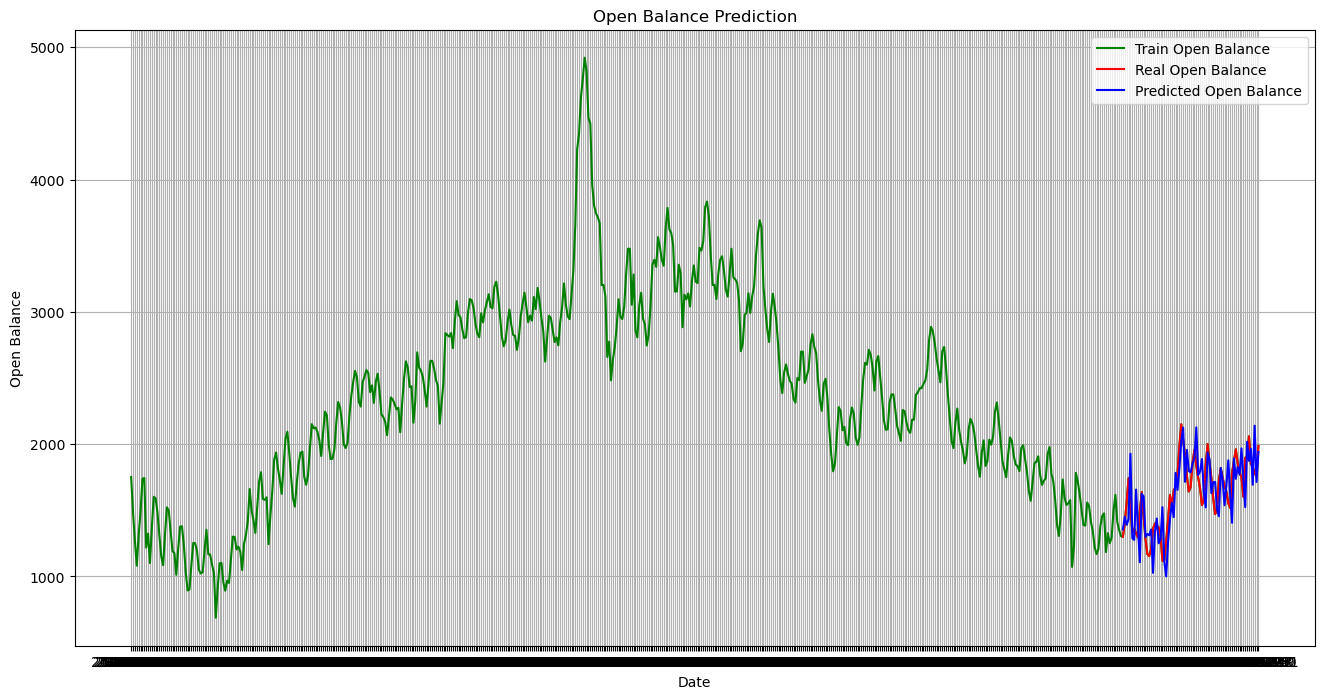

In [17]:
plt.figure(figsize=(16,8))
plt.plot(df_2022_2024.index[-600:], df_2022_2024['Open Balances'].tail(600), color='green', label = 'Train Open Balance')
plt.plot(test_data.index, y, color = 'red', label = 'Real Open Balance')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Open Balance')
plt.title('Open Balance Prediction')
plt.xlabel('Date')
plt.ylabel('Open Balance')
plt.legend()
plt.grid(True)
plt.show()